In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

futures_2020 = pd.read_csv("futures_2020_clean.csv")
futures_2021 = pd.read_csv("futures_2021_clean.csv")
weather_2020 = pd.read_csv("weather_2020.csv")
weather_2021 = pd.read_csv("weather_2021 (1).csv")

In [ ]:
df_prices = pd.concat([futures_2020, futures_2021], axis=0)
df_prices = df_prices.drop(columns=['Unnamed: 0'])
df_prices = df_prices.reset_index(drop=True)
df_prices['month'] = np.nan
def generate_month_list():
    months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
    month_pos = 0
    month_list = []
    for i in range(504):
        month = months[month_pos]
        month_list.append(month)
        if (i + 1) % 21 == 0:
            month_pos = (month_pos + 1) % 12
    return month_list

# Generate month list
month_list = generate_month_list()

# Add 'month' column to existing DataFrame
df_prices['month'] = month_list
df_prices

,SBL,month
0,56.316986,Jan
1,56.440153,Jan
2,56.044916,Jan
3,56.339452,Jan
4,56.177335,Jan
...,...,...
499,54.167613,Dec
500,54.366684,Dec
501,54.184475,Dec
502,54.564914,Dec


In [ ]:
weather_prices = pd.concat([weather_2020, weather_2021], axis=0)
weather_prices = weather_prices.drop(columns=['Unnamed: 0'])
weather_prices = weather_prices.reset_index(drop=True)
df = df_prices.join(weather_prices)
df

,SBL,month,weather
0,56.316986,Jan,1.013368
1,56.440153,Jan,1.223060
2,56.044916,Jan,-0.447239
3,56.339452,Jan,0.148754
4,56.177335,Jan,0.465278
...,...,...,...
499,54.167613,Dec,-0.504435
500,54.366684,Dec,0.163943
501,54.184475,Dec,1.181292
502,54.564914,Dec,1.365057


In [ ]:
df.describe()

,SBL,weather
count,504.000000,504.000000
mean,56.600876,0.799949
std,3.981208,1.886184
min,49.379183,-3.417405
25%,53.588935,-0.563396
50%,55.773399,0.749908
75%,59.821910,2.263927
max,65.792667,5.412454


Text(0.5, 1.0, 'Future Price Over Time')

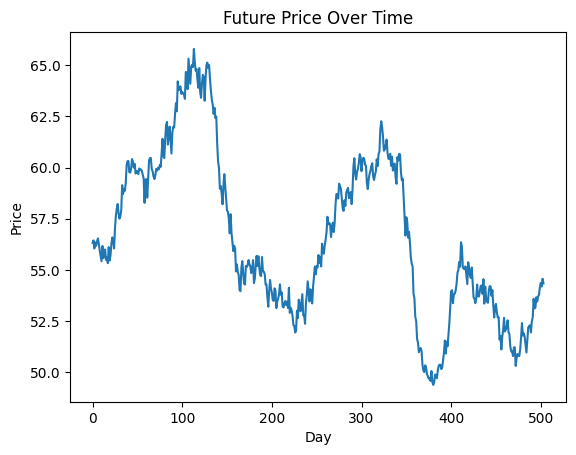

In [ ]:
sns.lineplot(data=df, x=df.index, y="SBL")
plt.xlabel("Day")
plt.ylabel("Price")
plt.title("Future Price Over Time")

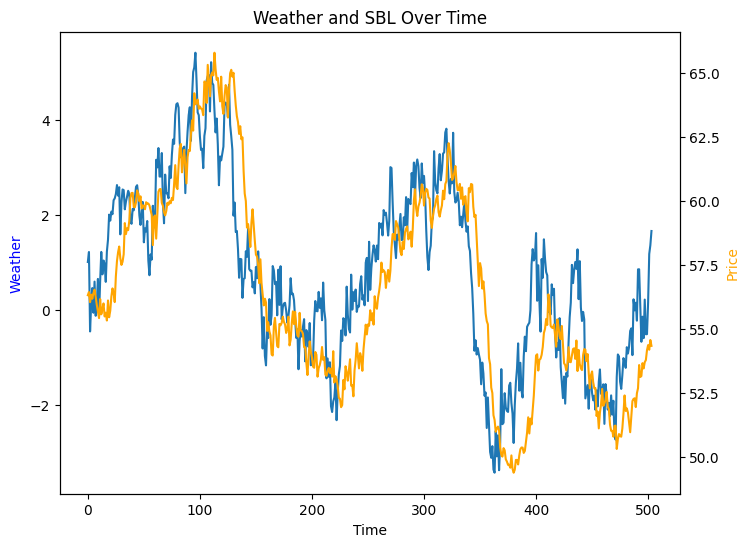

In [ ]:
fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()

# Plot the data on the first axis
sns.lineplot(data=df, x=df.index, y="weather", ax=ax1)

# Plot the data on the second axis
sns.lineplot(data=df, x=df.index, y="SBL", ax=ax2, color='orange')

# Set the labels and titles
ax1.set_xlabel('Time')
ax1.set_ylabel('Weather', color='blue')
ax2.set_ylabel('Price', color='orange')
ax1.set_title('Weather and SBL Over Time')

plt.show()

0.8479188974934266


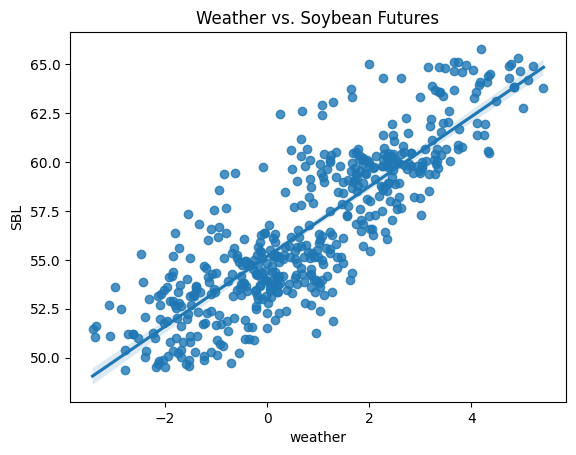

In [ ]:
sns.regplot(data=df, x="weather", y = "SBL")
plt.title("Weather vs. Soybean Futures")
print(np.corrcoef(df["weather"], df["SBL"])[0, 1])

<Axes: xlabel='SBL', ylabel='Count'>

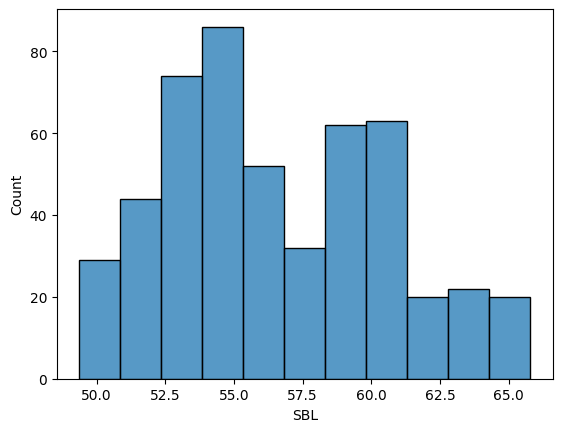

In [ ]:
sns.histplot(data=df, x="SBL")

Text(0.5, 1.0, 'Weather Over Time')

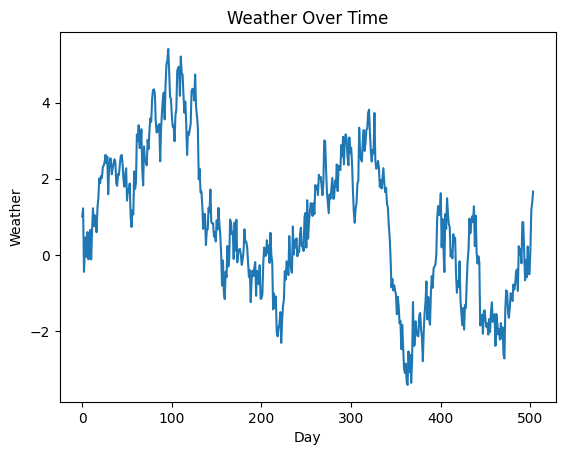

In [ ]:
sns.lineplot(data=df, x=df.index, y="weather")
plt.xlabel("Day")
plt.ylabel("Weather")
plt.title("Weather Over Time")

Text(0.5, 1.0, 'Weather Over Time')

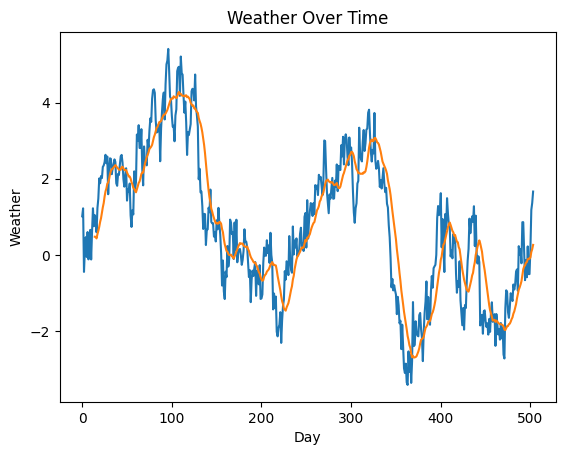

In [ ]:
weather_window_size = 15
smoothed_data = df["weather"].rolling(weather_window_size).mean()

#Plot data 
sns.lineplot(data=df, x=df.index, y="weather")
sns.lineplot(data=df, x=df.index, y=smoothed_data)
plt.xlabel("Day")
plt.ylabel("Weather")
plt.title("Weather Over Time")

In [ ]:
df["smoothed_data"] = smoothed_data
df

,SBL,month,weather,smoothed_data
0,56.316986,Jan,1.013368,NaN
1,56.440153,Jan,1.223060,NaN
2,56.044916,Jan,-0.447239,NaN
3,56.339452,Jan,0.148754,NaN
4,56.177335,Jan,0.465278,NaN
...,...,...,...,...
499,54.167613,Dec,-0.504435,-0.102868
500,54.366684,Dec,0.163943,-0.066480
501,54.184475,Dec,1.181292,0.075283
502,54.564914,Dec,1.365057,0.151046


In [ ]:
df.dropna()

,SBL,month,weather,smoothed_data
14,55.995417,Jan,1.044261,0.477110
15,55.485674,Jan,0.974233,0.474501
16,55.633577,Jan,0.594899,0.432623
17,55.327409,Jan,1.231189,0.544519
18,56.110775,Jan,1.482914,0.633463
...,...,...,...,...
499,54.167613,Dec,-0.504435,-0.102868
500,54.366684,Dec,0.163943,-0.066480
501,54.184475,Dec,1.181292,0.075283
502,54.564914,Dec,1.365057,0.151046


In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

#define train and test
n_train = 350
train = df["smoothed_data"].iloc[:n_train]
test = df["smoothed_data"].iloc[n_train:]

#Create SARIMA Model
weather_model = SARIMAX(train, order=(1, 2, 1), seasonal_order=(1, 2, 2, 12)).fit()
forecast = weather_model.forecast(steps=20)

#Evaluate Results
rmse = np.sqrt(np.mean((forecast - test)**2))


#Print Results
print(forecast)
print(f"RMSE: {rmse}")

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


350    0.445012
351    0.251694
352    0.009683
353   -0.206106
354   -0.408442
355   -0.564411
356   -0.757347
357   -0.990523
358   -1.242465
359   -1.506865
360   -1.741437
361   -1.963454
362   -2.170265
363   -2.415514
364   -2.715890
365   -2.984313
366   -3.235818
367   -3.435999
368   -3.684044
369   -3.972561
Name: predicted_mean, dtype: float64
RMSE: 0.4957995769991865
